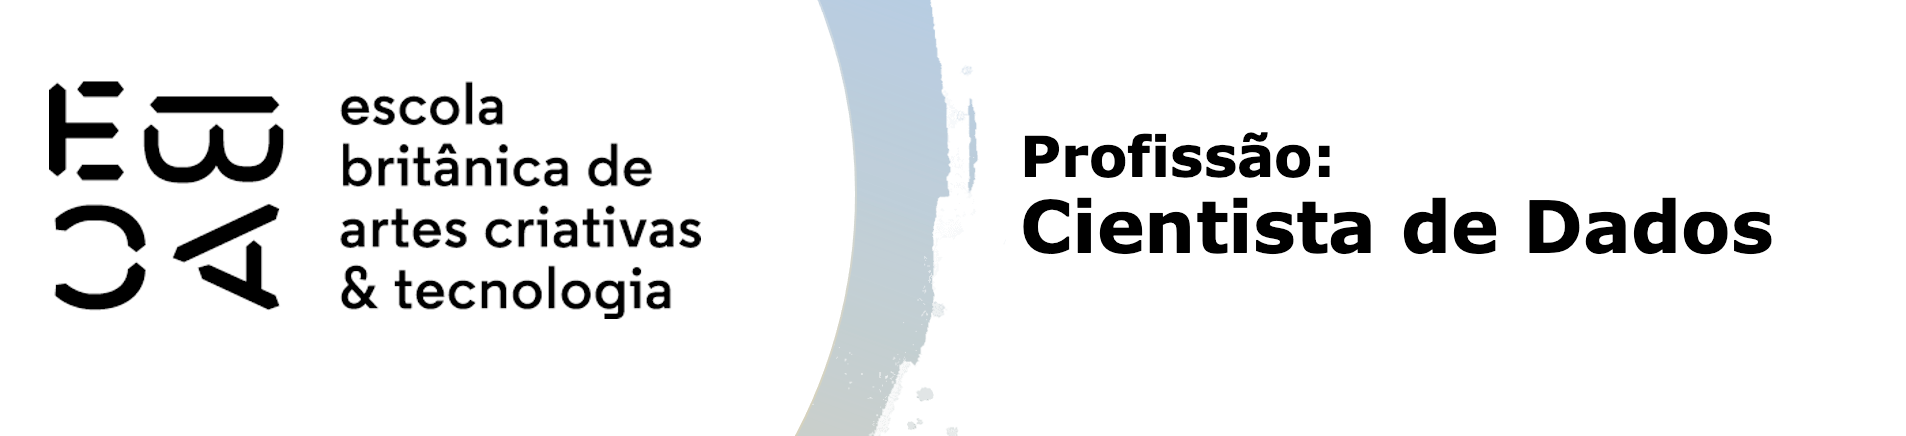

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [190]:
import pandas as pd
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif  
from sklearn.metrics import r2_score 
from scipy.interpolate import interp1d
import datetime 

df = pd.read_csv('previsao_de_renda_II.csv')
df['log_renda'] = np.log(df.renda)
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,7.793508
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,9.528769
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,7.767196
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,6.673020


In [191]:
custom_params = {"axes.spines.right":False,"axes.spines.top":False}
sns.set_theme(style='ticks',rc=custom_params)
color_palette = ['#264653','#e9c46a','#2a9d8f', '#f4a261', '#e76f51', '#8a5a44']

sns.set_palette(sns.color_palette(color_palette))
sns.color_palette(color_palette)

[(0.14901960784313725, 0.27450980392156865, 0.3254901960784314),
 (0.9137254901960784, 0.7686274509803922, 0.41568627450980394),
 (0.16470588235294117, 0.615686274509804, 0.5607843137254902),
 (0.9568627450980393, 0.6352941176470588, 0.3803921568627451),
 (0.9058823529411765, 0.43529411764705883, 0.3176470588235294),
 (0.5411764705882353, 0.35294117647058826, 0.26666666666666666)]

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               750000 non-null  object 
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          624240 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64
 14  log_renda              750000 non-nu

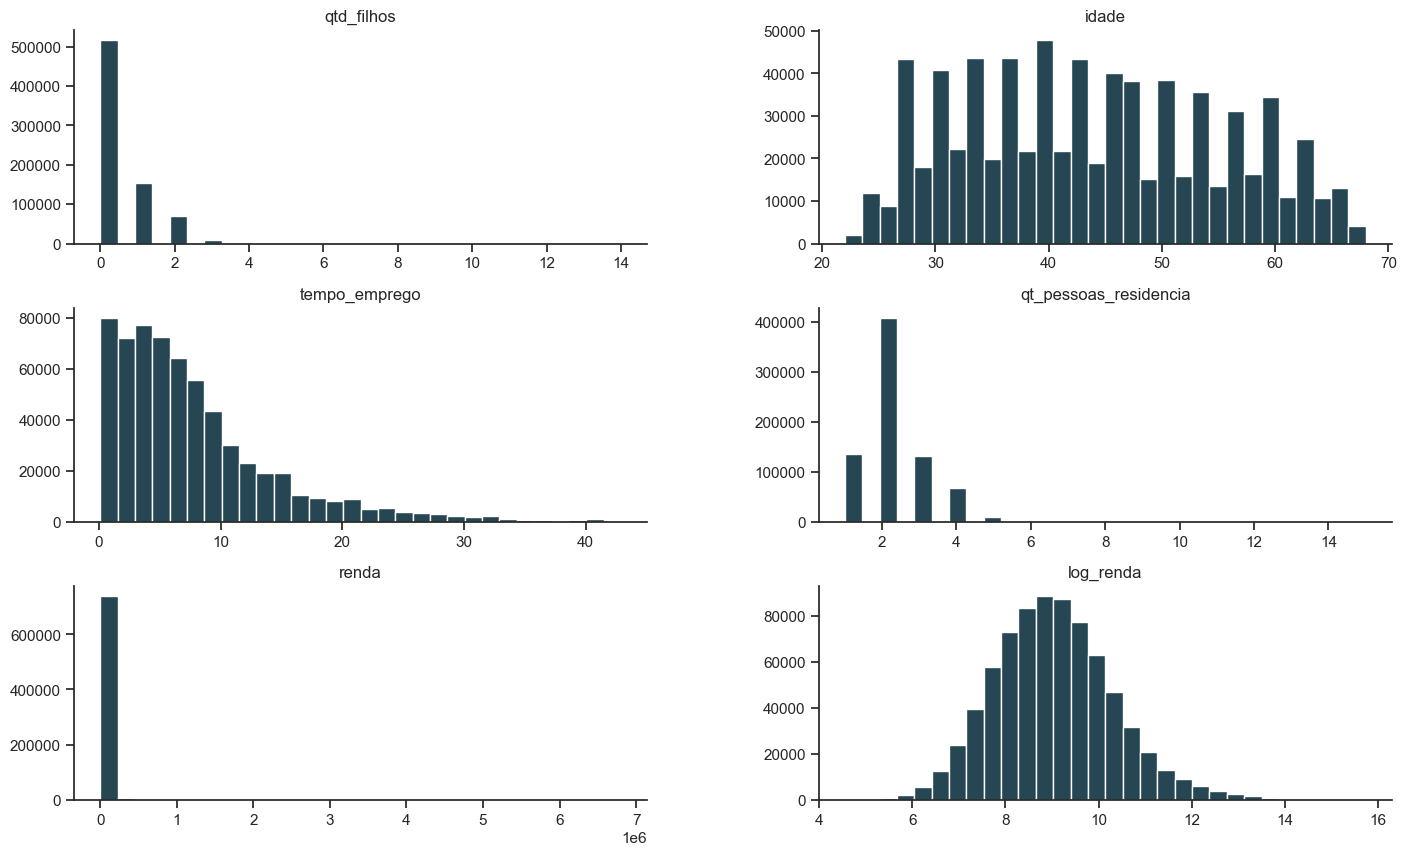

In [193]:
df.drop(columns=['index']).hist(bins=30,figsize=(17,10),grid=False);

In [194]:
df.fillna(value={"tempo_emprego": df.tempo_emprego.mean()}, inplace=True)

In [195]:
#Para fins didáticos e de processamento, vou dividar essa base para usar apenas uma fração dela.
#Para poder melhorar o desempenho da nossa atividade e n ficar muito temp esperando os modelos..
#Entao em resumo vou trabalhar com uma amostra para n atrapalhar muito o desempenho computacional na atividade, porém tudo isso poderia ser feito (e seria) com dados completos 

In [196]:
df['data_ref'] = pd.to_datetime(df['data_ref'])  

df['mes'] = df['data_ref'].dt.to_period('M')  
distribuicao_mensal = df['mes'].value_counts(normalize=True) 

# Definir o tamanho da amostra desejada 
tamanho_amostra = 25000

df_sample = df.groupby('mes', group_keys=False).apply(lambda x: x.sample(frac=tamanho_amostra / len(df)))
print(f"Tamanho da amostra final: {len(df_sample)} linhas")
df_sample.drop('mes',axis=1,inplace=True)

Tamanho da amostra final: 25005 linhas


C:\Users\User\AppData\Local\Temp\ipykernel_19372\2900081633.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('mes', group_keys=False).apply(lambda x: x.sample(frac=tamanho_amostra / len(df)))


In [197]:
df_train, df_test = train_test_split(df_sample, test_size=.2, random_state=420)
print(df_train.shape)
print(df_test.shape)

(20004, 15)
(5001, 15)


<Axes: xlabel='tempo_emprego', ylabel='log_renda'>

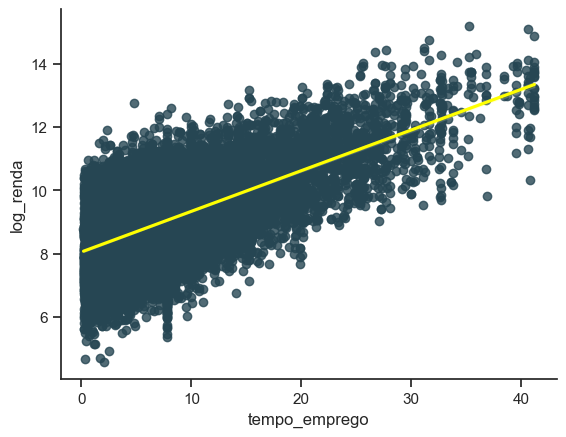

In [198]:
sns.regplot(data=df_train,x='tempo_emprego',y='log_renda',line_kws={'color':'yellow'})

In [199]:
lowess = sm.nonparametric.lowess(endog=df_train.log_renda, exog=df_train.tempo_emprego)

In [200]:
f_ = interp1d(x=lowess[:, 0], y=lowess[:, 1], bounds_error=False)

In [201]:
df_train["lowess"] = f_(df_train.tempo_emprego)
df_test["lowess"] = f_(df_test.tempo_emprego)

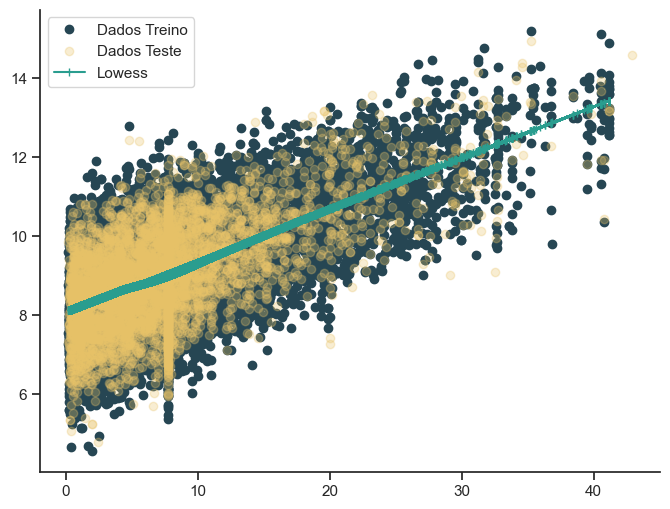

In [202]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df_train.tempo_emprego, df_train.log_renda, "o", label="Dados Treino", alpha=1)
ax.plot(df_test.tempo_emprego, df_test.log_renda, "o", label="Dados Teste", alpha=.3)
ax.plot(df_train.tempo_emprego, df_train.lowess, "|-", label="Lowess")
plt.legend()
plt.show()

In [203]:
res1 = smf.ols('log_renda ~ lowess',data=df_train).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                 1.193e+04
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:35:36   Log-Likelihood:                -28689.
No. Observations:               20004   AIC:                         5.738e+04
Df Residuals:                   20002   BIC:                         5.740e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0507      0.083      0.613      0.540      -0.111       0.213
lowess         0.9938      0.009    109.208      0.000       0.976       1.012
==============================================================================
Omnibus:                       87.595   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.702
Skew:                          -0.005   Prob(JB):                     8.92e-15
Kurtosis:                       2.722   Cond. No.                         106.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

---

#### Independência

A forma mais prática de verificar a independência é pelo gráfico de resíduos. Os resíduos não devem apresentar qualquer tipo de padrão com relação a qualquer outra variável. As checagens mais comuns são através da observação de gráficos de resíduos versus:

- A ordem dos dados
- Valores preditos
- Variáveis explicativas
- Qualquer outra variável


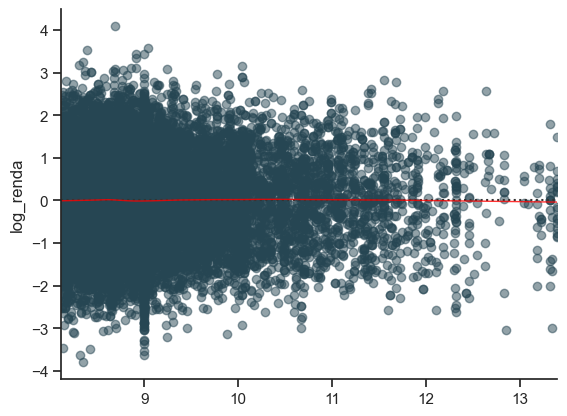

In [206]:
sns.residplot(data=df_train,x=res1.predict(),y='log_renda',lowess=True,scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

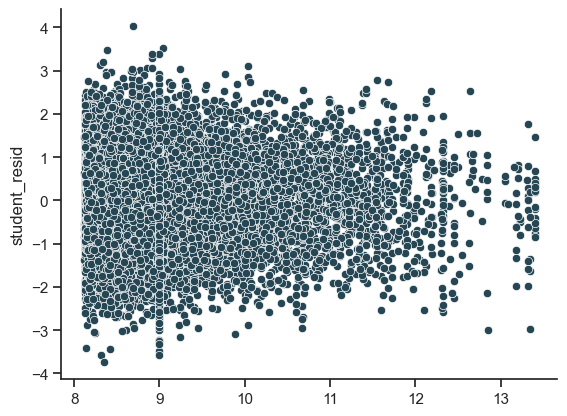

In [207]:
st_res = res1.outlier_test()
sns.scatterplot(x = res1.predict(), y = st_res.student_resid);

#### Distribuição Normal

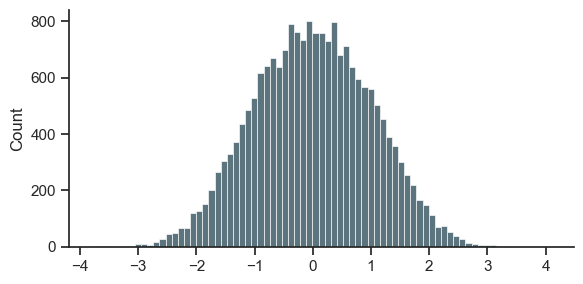

In [209]:
sns.displot(res1.resid, height=3, aspect=2);

#### Mesma variância

<Axes: ylabel='None'>

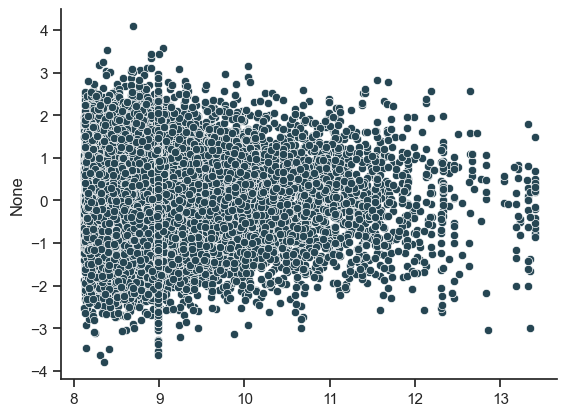

In [211]:
sns.scatterplot(x = res1.predict(), y = res1.resid)

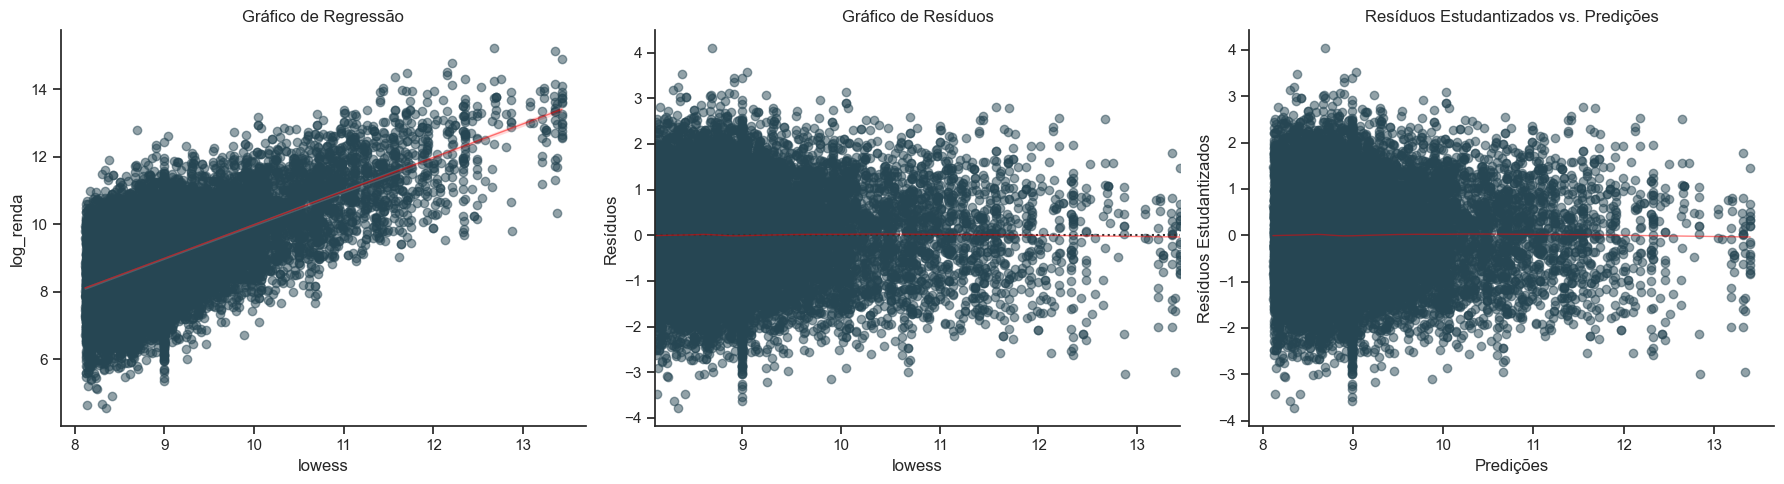

In [245]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))


sns.regplot(ax=ax[0], 
            data=df_train, 
            x="lowess", 
            y="log_renda", 
            scatter_kws={"alpha":.5},  
            line_kws={"color":"red", "lw":1, "alpha":.5})  




sns.residplot(ax=ax[1], 
              data=df_train, 
              x="lowess", 
              y="log_renda", 
              lowess=True,  
              scatter_kws={"alpha":.5}, 
              line_kws={"color":"red", "lw":1, "alpha":.5})




sns.regplot(ax=ax[2], 
            x=res1.predict(),  # Predições do modelo
            y=res1.outlier_test().student_resid,  # Resíduos estudantizados
            scatter_kws={"alpha":.5}, 
            line_kws={"color":"red", "lw":1, "alpha":.5}, 
            lowess=True)



# Ajusta o layout dos gráficos para evitar sobreposição
plt.tight_layout()
plt.show()

**As suposições do modelo não estão totalmente atendidas. Observamos o seguinte:**
1. **Distribuição dos Resíduos:** Os resíduos (diferença entre valores reais e previstos) têm uma forma que sugere uma distribuição normal, o que é bom.

2. **Gráfico de Resíduos:** A dispersão dos resíduos mostra alguns problemas. Parece que a variância dos resíduos não é constante em todas as predições, o que pode indicar heterocedasticidade (variação não constante).
ante.

3. **Relação com a Data de Referência:** Existe uma relação clara entre os resíduos e a data de referência. Isso sugere que o modelo não está capturando bem a variação temporal, o que pode afetar a precisão das previsões.

*Em resumo, o modelo pode precisar de ajustes para lidar melhor com a variação ao longo do tempo e para garantir que a variância dos resíduos seja constante.*

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

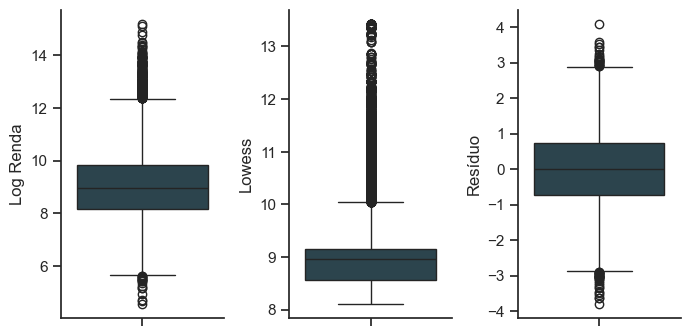

In [229]:
fix, ax = plt.subplots(1, 3, figsize=(8,4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y = 'log_renda',data=df_train, ax=ax[0])
sns.boxplot(y = 'lowess',data=df_train, ax=ax[1])
sns.boxplot(y = res1.resid ,data=df_train, ax=ax[2]);

ax[0].set_ylabel('Log Renda')
ax[1].set_ylabel('Lowess')
ax[2].set_ylabel('Resíduo');

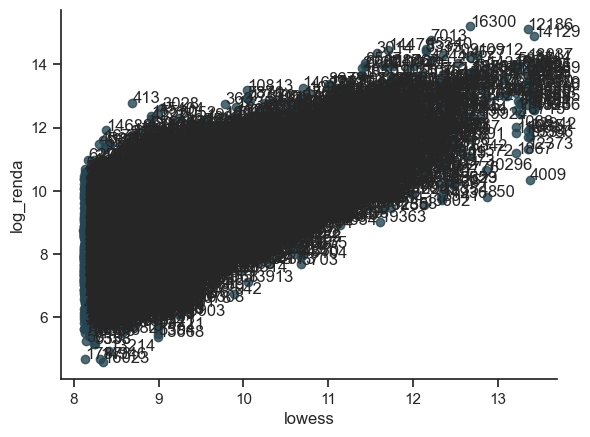

In [233]:
fig, ax = plt.subplots()

sns.regplot(x = 'lowess', y = 'log_renda', data=df_train, ax=ax)

moment_ = df_train.reset_index()

for i, txt in enumerate(moment_.index.values):
        ax.annotate(str(txt), (moment_.loc[i,'lowess'], moment_.loc[i,'log_renda']))

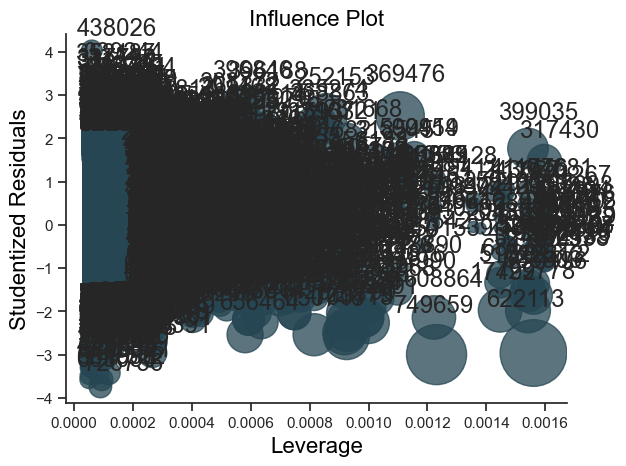

In [241]:
fig = sm.graphics.influence_plot(res1, criterion="cooks")
fig.tight_layout(pad=1.0)

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

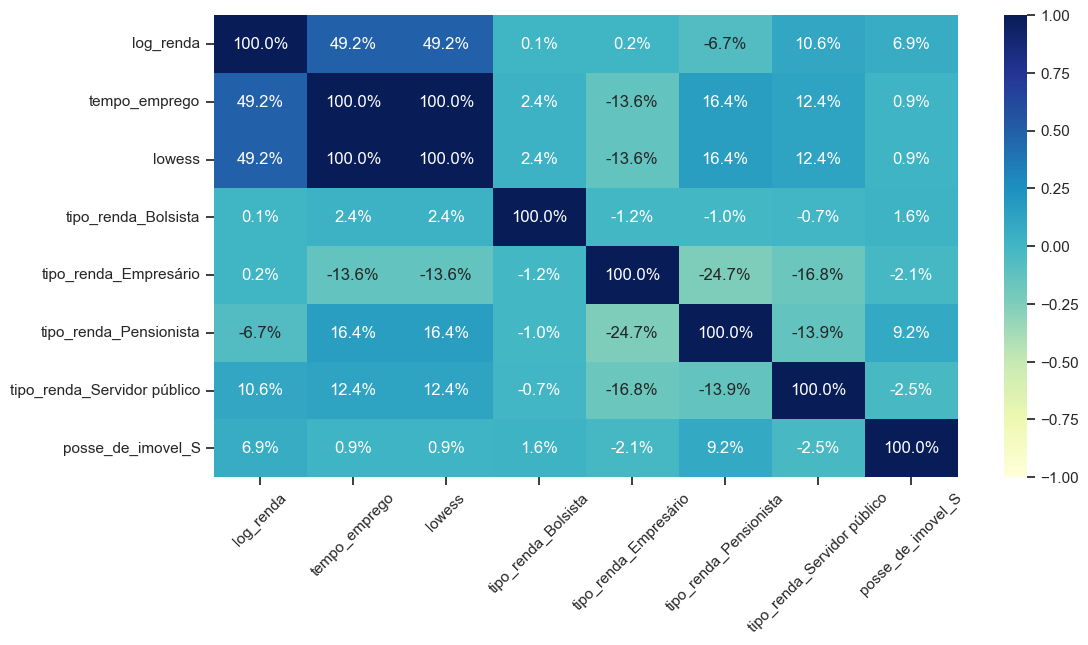

In [264]:
plt.figure(figsize=(12, 6))

sns.heatmap(pd.get_dummies(data=df_train[["log_renda", "tempo_emprego", "lowess", "tipo_renda", "posse_de_imovel"]], drop_first=True).corr(method="spearman"),
            annot=True,
            fmt=".1%",  
            cmap="YlGnBu",
           vmin=-1)  
              

plt.xticks(rotation=45)

# Exibe o gráfico de calor (heatmap) com a matriz de correlação de Spearman
plt.show()

In [266]:
# Calculando o Fator de Inflação da Variância (VIF) para detectar multicolinearidade

# Definindo as colunas para as quais o VIF será calculado
columns = ["tempo_emprego", "posse_de_imovel", "tipo_renda"]

# Criando variáveis dummies para as variáveis categóricas
df_train_dummies = pd.get_dummies(data=df_train[columns], drop_first=True, dtype=int)

# Criando um DataFrame vazio para armazenar os valores de VIF e os nomes das features
df_vif = pd.DataFrame()

# Calculando o VIF para cada variável independente no DataFrame de treino transformado em dummies
df_vif["VIF Factor"] = [vif(df_train_dummies, i) for i in range(df_train_dummies.shape[1])]

# Adicionando uma coluna com os nomes das features
df_vif["Feature"] = df_train_dummies.columns

# Exibindo o DataFra

In [268]:
df_vif.round(2)

,VIF Factor,Feature
0,1.89,tempo_emprego
1,1.99,posse_de_imovel_S
2,1.00,tipo_renda_Bolsista
3,1.25,tipo_renda_Empresário
4,1.26,tipo_renda_Pensionista
5,1.16,tipo_renda_Servidor público


In [274]:
res2 = smf.ols(" log_renda ~  tempo_emprego + C(posse_de_imovel) + C(tipo_renda)",data=df_train).fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     2098.
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:44:19   Log-Likelihood:                -28483.
No. Observations:               20004   AIC:                         5.698e+04
Df Residuals:                   19997   BIC:                         5.704e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             7.9044      0.017    472.966      0.000       7.872       7.937
C(posse_de_imovel)[T.S]               0.2111      0.015     13.915      0.000       0.181       0.241
C(tipo_renda)[T.Bolsista]            -0.3750      0.318     -1.179      0.238      -0.998       0.248
C(tipo_renda)[T.Empresário]           0.1434      0.018      8.013      0.000       0.108       0.178
C(tipo_renda)[T.Pensionista]         -0.2496      0.020    -12.488      0.000      -0.289      -0.210
C(tipo_renda)[T.Servidor público]     0.1171      0.026      4.449      0.000       0.066       0.169
tempo_emprego                         0.1291      0.001    108.606      0.000       0.127       0.131
==============================================================================
Omnibus:                       92.196   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.654
Skew:                          -0.009   Prob(JB):                     2.04e-15
Kurtosis:                       2.716   Cond. No.                         441.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

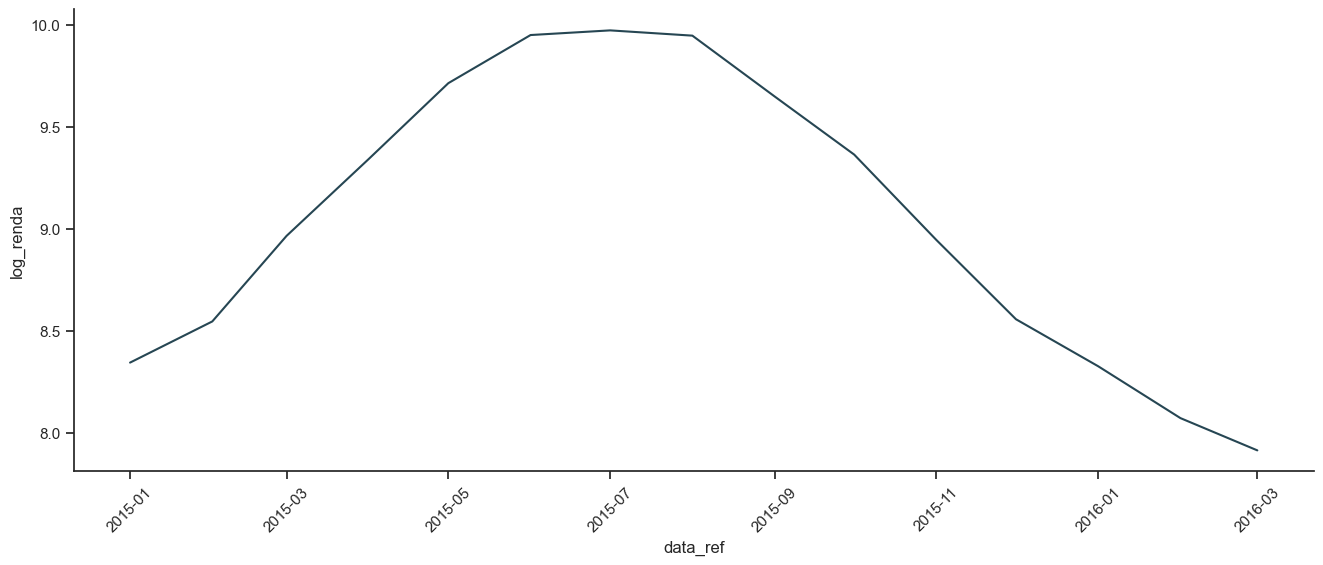

In [278]:
# Criando um gráfico de linha para mostrar a média de 'renda_log' ao longo do tempo (data_ref)

plt.figure(figsize=(16,6))  # Define o tamanho da figura

# Agrupa os dados de treino por 'data_ref' e calcula a média de 'renda_log' para cada data
sns.lineplot(data=df_train.groupby(by="data_ref").log_renda.mean())

# Rotaciona os rótulos do eixo x para que as datas fiquem mais legíveis
plt.xticks(rotation=45)

# Exibe o gráfico
plt.show()

In [282]:
# Ajustando 'renda_log' para remover a influência da variável 'data_ref'
# Subtrai a média de 'renda_log' para cada data de referência ('data_ref') de cada valor individual de 'renda_log'
# O objetivo é ajustar a variável 'renda_log' sem a influência de 'data_ref', conforme avaliado no gráfico anterior

df_train["renda_log_data_ref"] = df_train.log_renda - df_train.data_ref.map(df_train["log_renda"].groupby(by=df_train.data_ref).mean())

# Exibindo o DataFrame com a nova coluna 'renda_log_data_ref' que representa 'renda_log' ajustada
df_train

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda,lowess,renda_log_data_ref
161654,2015-04-01,9393,M,S,N,0,Assalariado,Médio,Casado,Casa,48,7.101370,2.0,18774.13,9.840235,8.919292,0.497293
238975,2015-05-01,9742,M,N,N,0,Assalariado,Médio,Casado,Casa,28,3.449315,2.0,3208.14,8.073447,8.534666,-1.640698
530054,2015-11-01,16549,F,N,S,0,Assalariado,Médio,Casado,Casa,55,10.136986,2.0,10739.12,9.281648,9.328938,0.335738
272839,2015-06-01,1422,F,S,S,0,Pensionista,Superior completo,Casado,Casa,62,7.746165,2.0,70027.65,11.156645,8.995199,1.206787
210311,2015-05-01,3327,F,N,N,0,Empresário,Superior completo,Casado,Casa,40,5.490411,2.0,18057.75,9.801330,8.758201,0.087186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419259,2015-09-01,3087,M,S,N,0,Assalariado,Superior completo,Separado,Casa,33,14.975342,1.0,32165.48,10.378649,10.014831,0.729534
552118,2015-12-01,8207,F,N,S,1,Assalariado,Superior completo,União,Casa,44,14.978082,3.0,13107.66,9.480952,10.015220,0.923206
649300,2016-01-01,13823,F,S,S,0,Empresário,Superior completo,Casado,Casa,27,7.624658,2.0,5498.18,8.612172,8.980242,0.284772
601192,2016-01-01,14003,F,N,S,1,Servidor público,Médio,Casado,Casa,40,7.120548,3.0,7651.68,8.942681,8.921517,0.615280


In [284]:
# Realizando uma nova regressão linear múltipla ajustada

reg_ajuste = smf.ols(formula="renda_log_data_ref ~ tempo_emprego + C(tipo_renda) + C(posse_de_imovel)", data=df_train).fit()


reg_ajuste.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     renda_log_data_ref   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     4032.
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:49:19   Log-Likelihood:                -21973.
No. Observations:               20004   AIC:                         4.396e+04
Df Residuals:                   19997   BIC:                         4.402e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.1376      0.012    -94.256      0.000      -1.161      -1.114
C(tipo_renda)[T.Bolsista]            -0.0579      0.230     -0.252      0.801      -0.508       0.392
C(tipo_renda)[T.Empresário]           0.1590      0.013     12.302      0.000       0.134       0.184
C(tipo_renda)[T.Pensionista]         -0.2482      0.014    -17.198      0.000      -0.276      -0.220
C(tipo_renda)[T.Servidor público]     0.1102      0.019      5.796      0.000       0.073       0.147
C(posse_de_imovel)[T.S]               0.2068      0.011     18.873      0.000       0.185       0.228
tempo_emprego                         0.1294      0.001    150.709      0.000       0.128       0.131
==============================================================================
Omnibus:                        6.884   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                7.380
Skew:                          -0.003   Prob(JB):                       0.0250
Kurtosis:                       3.094   Cond. No.                         441.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [312]:
df_train.log_renda

161654     9.840235
238975     8.073447
530054     9.281648
272839    11.156645
210311     9.801330
            ...    
419259    10.378649
552118     9.480952
649300     8.612172
601192     8.942681
309256     9.270181
Name: log_renda, Length: 20004, dtype: float64

In [374]:
#Teste

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
df_scaled_train = scaler.fit_transform((df_train
                                  .select_dtypes(include='number')
                                  .drop(columns=['renda','log_renda'])
                                 ))

'''df_scaled_test = scaler.transform((df_test
                                  .select_dtypes(include='number')
                                  .drop(columns=['renda','log_renda'])
                                 ))'''
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(df_scaled_train)
'''X_test_pca = pca.transform(df_scaled_test)'''

pca_df = pd.DataFrame(X_train_pca,columns=['C1','C2'])


In [376]:
df_train['log_renda'].reset_index().drop('index',axis=1)

,log_renda
0,9.840235
1,8.073447
2,9.281648
3,11.156645
4,9.801330
...,...
19999,10.378649
20000,9.480952
20001,8.612172
20002,8.942681


In [378]:
pca_df['log_renda_'] =df_train['log_renda'].reset_index().drop('index',axis=1)

In [380]:
pca_df

,C1,C2,log_renda_
0,0.341732,-0.567475,9.840235
1,-1.691877,-0.697676,8.073447
2,0.930484,-0.513852,9.281648
3,1.186540,-0.819622,11.156645
4,-0.231296,-0.584754,9.801330
...,...,...,...
19999,1.854582,-0.271639,10.378649
20000,1.412405,1.724756,9.480952
20001,-0.215589,0.025949,8.612172
20002,-0.358649,1.240301,8.942681


In [382]:
reg3 = smf.ols('log_renda_ ~ C1 + C2 ',data=pca_df).fit()
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_renda_   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 1.078e+04
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:07:32   Log-Likelihood:                -26051.
No. Observations:               20004   AIC:                         5.211e+04
Df Residuals:                   20001   BIC:                         5.213e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.0394      0.006   1436.546      0.000       9.027       9.052
C1             0.5143      0.004    136.771      0.000       0.507       0.522
C2             0.2371      0.004     53.406      0.000       0.228       0.246
==============================================================================
Omnibus:                      387.618   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.687
Skew:                          -0.026   Prob(JB):                     1.08e-46
Kurtosis:                       2.499   Cond. No.                         1.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [384]:
# Calcula a média de 'renda_log' para cada 'data_ref' no DataFrame de treino
data_map = df_train.log_renda.groupby(df_train.data_ref).mean()

# Estima os valores de 'renda_log' para o DataFrame de teste
# Adiciona a previsão da regressão ajustada à média de 'renda_log' por 'data_ref'
renda_log_pred = df_test.data_ref.map(data_map) + reg_ajuste.predict(df_test)

# Calcula o coeficiente de determinação (R²) para avaliar o desempenho do modelo ajustado
r2 = r2_score(y_true=df_test.log_renda, y_pred=renda_log_pred)

# Exibe o R² como uma porcentagem
print("{:.2%}".format(r2))

67.97%
